### **Problem Definition :**
In the fast-paced retail sector, the ability to anticipate future sales plays a
vital role in both day-to-day operations and long-term planning. Forecasting
product sales involves estimating the quantity of items a store is likely to sell in upcoming periods, using past performance data and a variety of influencing factors. These include store classification, geographic location, regional demographics, marketing campaigns, and time-related elements such as holidays and seasonal patterns. This project aims to build a forecasting model that leverages historical sales records from multiple stores to predict future sales outcomes with greater accuracy.

## **Import important Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

## **Loading Dataset**

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/ProductSalesForecasting/TRAIN.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/ProductSalesForecasting/TEST_FINAL.csv')

## **Shape of Dataset**

In [4]:
train.shape, test.shape

((188340, 10), (22265, 8))

In [5]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


**“Date” Column is not in datetime format. Also need to change “Store_Type” , “Region_Code” , “Location_Type” , “Holiday” , “Discount” to categorical data type.**

In [7]:
train['Date'] = pd.to_datetime(train['Date'])

In [8]:
train['Store_Type'] = train['Store_Type'].astype('category')
train['Location_Type'] = train['Location_Type'].astype('category')
train['Region_Code'] = train['Region_Code'].astype('category')

In [9]:
train.rename(columns={'#Order': 'Order'}, inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  category      
 3   Location_Type  188340 non-null  category      
 4   Region_Code    188340 non-null  category      
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   Order          188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 10.6+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


**“Date” Column is not in datetime format. Also need to change “Store_Type” , “Region_Code” , “Location_Type” , “Holiday” , “Discount” to categorical data type.**

In [12]:
test['Date'] = pd.to_datetime(test['Date'])
test['Store_Type'] = test['Store_Type'].astype('category')
test['Location_Type'] = test['Location_Type'].astype('category')
test['Region_Code'] = test['Region_Code'].astype('category')

## **Missing Values**

In [13]:
train.isna().sum()

,0
ID,0
Store_id,0
Store_Type,0
Location_Type,0
Region_Code,0
Date,0
Holiday,0
Discount,0
Order,0
Sales,0


**There are no missing values in dataset.**

## **Check for duplicates**

In [14]:
train.duplicated().sum()

np.int64(0)

In [15]:
 test.duplicated().sum()

np.int64(0)

**There are no duplicate rows in dataset.**

## **Check for outliers**

<Axes: xlabel='Sales'>

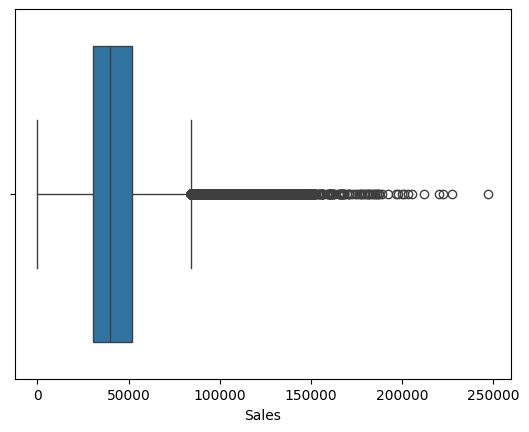

In [16]:
sns.boxplot(x=train['Sales'])

**The sales column contained outliers that could potentially distort analysis and model performance. To address this, we applied clipping based on the 5th and 95th percentiles.**

In [17]:
# Calculate the 5th and 95th percentiles
lower = train['Sales'].quantile(0.05)
upper = train['Sales'].quantile(0.95)

# Clip the 'Sales' column
train['Sales'] = train['Sales'].clip(lower, upper)

**This means that all values below the 5th percentile were set to the 5th percentile value, and all values above the 95th percentile were set to the 95th percentile value. This method preserves the overall structure and range of the data while reducing the influence of extreme outliers, helping to ensure more robust and reliable insights in downstream analysis or modeling.**

<Axes: xlabel='Sales'>

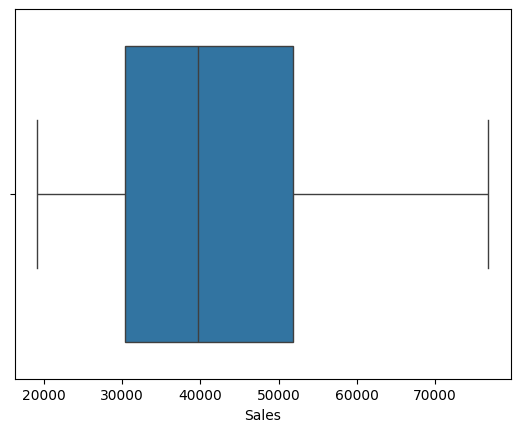

In [18]:
sns.boxplot(x=train['Sales'])

## **Creating Performance Metrics**

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def performance(y_true, y_pred):
    # Avoid divide by zero in MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return mae , rmse , mape

# **ML Modeling**

# **LINEAR REGRESSION**

In [20]:
train_df = train.copy()

In [21]:
test_df = test.copy()

### **Data Processing**

In [22]:
# Save ID column for later (if needed for output)
train_ids = train_df['ID']
test_ids = test_df['ID']

In [23]:
train_df['Date']=train_df['Date'].astype('datetime64[ns]')
test_df['Date']=test_df['Date'].astype('datetime64[ns]')

### **Feature Engineering**

In [24]:
for df in [train_df, test_df]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

In [28]:
# Sort data for proper time operations
train_df = train_df.sort_values(by=['Store_id', 'Date'])

# Lag features
train_df['Sales_lag_1'] = train_df.groupby('Store_id')['Sales'].shift(1)
train_df['Sales_lag_7'] = train_df.groupby('Store_id')['Sales'].shift(7)
train_df['Sales_lag_14'] = train_df.groupby('Store_id')['Sales'].shift(14)

# Rolling average features
train_df['Sales_last_7'] = train_df.groupby('Store_id')['Sales'].shift(1).rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
train_df['Sales_last_3'] = train_df.groupby('Store_id')['Sales'].shift(1).rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)


In [25]:
# Drop it before encoding or model training
train_df.drop(columns=['ID'], inplace=True)
test_df.drop(columns=['ID'], inplace=True)

In [26]:
# Convert 'Discount' from Yes/No to 1/0
for df in [train_df, test_df]:
    df['Discount'] = df['Discount'].map({'Yes': 1, 'No': 0})

### **Data Transformation - One Hot Encoding**

In [27]:
# One-hot encode other categorical columns
categorical_cols = ['Store_Type', 'Location_Type', 'Region_Code']
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

In [29]:
train_df.head()

,Store_id,Date,Holiday,Discount,Order,Sales,Year,Month,Day,DayOfWeek,...,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_last_7,Sales_last_3
0,1,2018-01-01,1,1,9,19191.0,2018,1,1,0,...,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN
607,1,2018-01-02,0,1,60,42369.0,2018,1,2,1,...,False,True,False,False,False,19191.0,NaN,NaN,45453.188571,54875.94
1046,1,2018-01-03,0,1,72,50037.0,2018,1,3,2,...,False,True,False,False,False,42369.0,NaN,NaN,63491.871429,67099.70
1207,1,2018-01-04,0,1,64,44397.0,2018,1,4,3,...,False,True,False,False,False,50037.0,NaN,NaN,57063.900000,64769.10
1752,1,2018-01-05,0,1,63,47604.0,2018,1,5,4,...,False,True,False,False,False,44397.0,NaN,NaN,45287.142857,48082.00


In [30]:
train_df.dropna(inplace = True )    #Drop bcoz nan rows will b created)

In [31]:
train_df.columns

Index(['Store_id', 'Date', 'Holiday', 'Discount', 'Order', 'Sales', 'Year',
       'Month', 'Day', 'DayOfWeek', 'IsWeekend', 'Store_Type_S1',
       'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4', 'Sales_lag_1', 'Sales_lag_7',
       'Sales_lag_14', 'Sales_last_7', 'Sales_last_3'],
      dtype='object')

### **Train - Test Split**

In [32]:
# Drop 'Date' column from features
train_df_x = train_df.drop(columns=['Sales', 'Date'])
train_df_y = train_df['Sales']

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.3, random_state=42)

In [34]:
X_train.head()

,Store_id,Holiday,Discount,Order,Year,Month,Day,DayOfWeek,IsWeekend,Store_Type_S1,...,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_last_7,Sales_last_3
182185,51,0,1,64,2019,5,15,2,0,True,...,False,False,True,False,False,27882.00,24600.0,38985.0,70924.500000,73918.1
47436,345,0,0,41,2018,5,10,3,0,True,...,False,False,False,True,False,34351.02,44754.0,32010.0,33869.991429,27996.0
127366,344,0,0,69,2018,12,15,5,1,True,...,True,True,False,False,False,27954.00,45984.0,40980.0,41085.265714,40416.0
69789,302,0,0,46,2018,7,11,2,0,True,...,False,False,True,False,False,26268.00,36750.0,32529.0,24893.571429,20043.0
103318,203,0,0,22,2018,10,11,3,0,False,...,False,False,True,False,False,39279.00,22965.0,29571.0,50607.428571,46024.0


In [35]:
from sklearn.linear_model import LinearRegression

# 1. Initialize the model
lr_model = LinearRegression()

# . Train the model
lr_model.fit(X_train,y_train)

# 3. Predict on training and validation sets
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

### **Evaluation of Linear Regression Model**

In [38]:
print ("Train Prediction Result :")
print(performance(y_train, y_train_pred))

Train Prediction Result :
MAE: 3664.98
RMSE: 5187.01
MAPE: 9.10%
(3664.9805597266213, np.float64(5187.005645866653), np.float64(9.102814604590954))


In [39]:
print ("Test Prediction Result :")
print(performance(y_test, y_test_pred))

Test Prediction Result :
MAE: 3625.08
RMSE: 5117.61
MAPE: 9.02%
(3625.0750007091146, np.float64(5117.605954657228), np.float64(9.020439076029675))


**The model predicts with an average absolute percentage error of 9.02%, indicating high accuracy.
On average, predictions deviate by 3625 units, with larger errors moderately penalized, as shown by the RMSE of 5117**

# **Random Forest Regressor**

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

In [41]:
# Define hyperparameters for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 100),   # Random range for n_estimators (number of trees)
    'max_depth': randint(5,10),         # Random range for max_depth of the trees
    'min_samples_split': randint(2, 10), # Random range for minimum samples to split
    'min_samples_leaf': randint(1, 5),   # Random range for minimum samples at leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Random choice of max features for each split
    'bootstrap': [True, False]  # Whether to use bootstrapping (sampling with replacement)
}



In [42]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

**To optimize the Random Forest model, we use Randomized Search Cross-Validation (RandomizedSearchCV) to efficiently explore a wide range of hyperparameter combinations. Instead of trying every possible combination like grid search, it samples a fixed number of random configurations, saving time while still identifying strong parameter settings. This helps find the best hyperparameters — such as the number of trees, maximum depth, and minimum samples per leaf — that improve the model’s predictive performance and generalization.**

In [43]:
# Initialize RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=10,          # Number of random combinations to try
                                   scoring='neg_mean_absolute_error',  # Optimization criteria
                                   cv=3,               # 5-fold cross-validation
                                   verbose=2,          # Output progress
                                   n_jobs=-1,          # Use all cores for computation
                                   random_state=42)

In [44]:
# Fit the model to training data
random_search.fit(X_train,y_train)

# Print best parameters found
print("Best parameters found: ", random_search.best_params_)

# Get the best estimator (the model with optimal parameters)
best_rf_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 79}


**Training with Best parameters found**

In [45]:
best_params = {
    'bootstrap': True,
    'max_depth': 9,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'n_estimators': 79,
    'random_state': 42
}

rf_final = RandomForestRegressor(**best_params)
rf_final.fit(X_train,y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=79, random_state=42)

In [46]:
y_train_preds = rf_final.predict(X_train)
y_test_preds = rf_final.predict(X_test)

### **Evaluation of Random Forest Regressor**

In [47]:
performance(y_train, y_train_preds)

MAE: 3377.20
RMSE: 4471.20
MAPE: 8.77%


(3377.2014810851174,
 np.float64(4471.204498724363),
 np.float64(8.770074291505328))

In [48]:
performance(y_test, y_test_preds)

MAE: 3426.91
RMSE: 4523.66
MAPE: 8.90%


(3426.9058119467154,
 np.float64(4523.656061492396),
 np.float64(8.896182446236251))

**The Mean Absolute Percentage Error (MAPE) is 9.44%, showing that on average, the predictions deviate from the true values by roughly 9.44%.**

# **XGBOOST**

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

param_dist = {
    "n_estimators": randint(100, 500),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 1),  # L1 regularization
    "reg_lambda": uniform(0, 1), # L2 regularization
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


### **Evaluton of XGBoost**

In [50]:
y_train_pred = best_model.predict(X_train)

In [51]:
y_test_pred = best_model.predict(X_test)

In [52]:
performance(y_train, y_train_pred)

MAE: 796.58
RMSE: 1059.64
MAPE: 1.99%


(796.5830011588915,
 np.float64(1059.6350823141886),
 np.float64(1.9879530241735988))

In [53]:
performance(y_test,y_test_pred)

MAE: 1058.42
RMSE: 1440.56
MAPE: 2.58%


(1058.4228018590588,
 np.float64(1440.5629562600752),
 np.float64(2.5820510616823054))

**The MAPE of 2.58% shows that, on average, the model’s predictions are within 2.6% of the actual sales values. These results reflect a significant improvement in accuracy, demonstrating that XGBoost effectively captured the underlying patterns in the data.**

In [54]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9754141089595671), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(1.8107728991724996), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.12109845047028002), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=301, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### **Time Series Models**

# **ARIMA**

In [60]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [61]:
train_df = train.copy()
test_df = test.copy()

In [62]:
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,19191.00
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [63]:
# Make sure 'Date' is datetime and sorted
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.sort_values('Date')

# Group by Date to create univariate series
sales_ts = train_df.groupby('Date')['Sales'].sum()

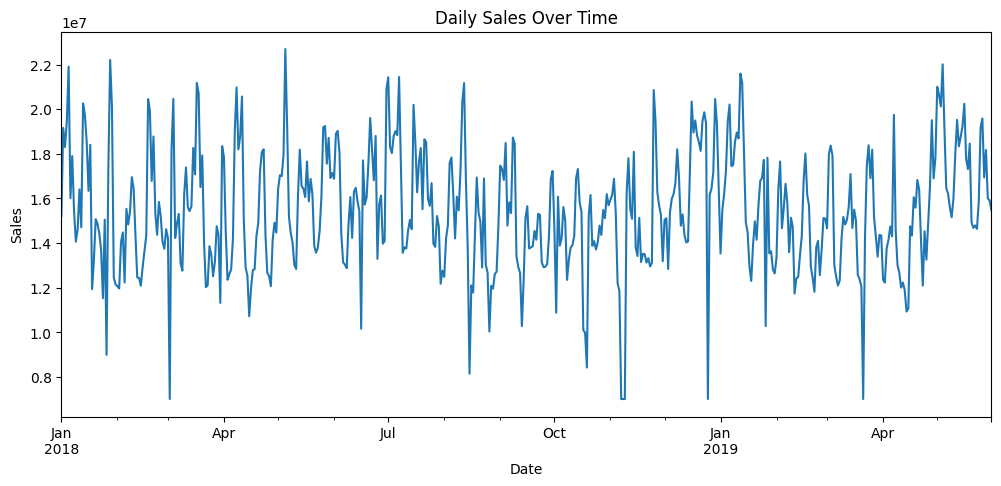

In [64]:
sales_ts.plot(figsize=(12, 5), title='Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### **Verifying stationary of data**

In [65]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):

  # Perform the ADF test
  result = adfuller(timeseries)

  # Extract and display the test results
  print("ADF Statistic:", result[0])
  print("p-value:", round(result[1],4))
  #print("Critical Values:", result[4])

  # Interpret the result
  if result[1] < 0.05:
     print("The time series is stationary.")
  else:
      print("The time series is non-stationary.")


In [66]:
adf_test(sales_ts)

ADF Statistic: -3.446020484119231
p-value: 0.0095
The time series is stationary.


**Timeseries we have taken is stationary.**

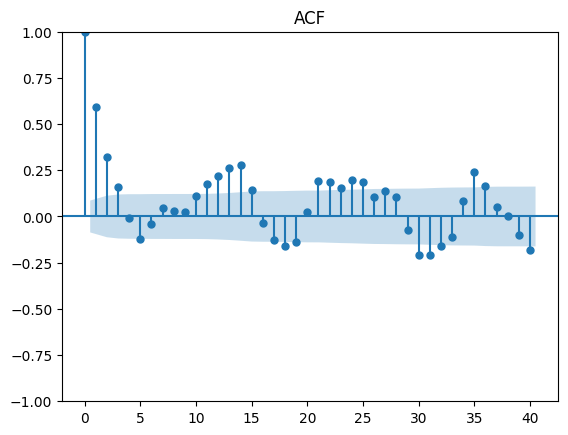

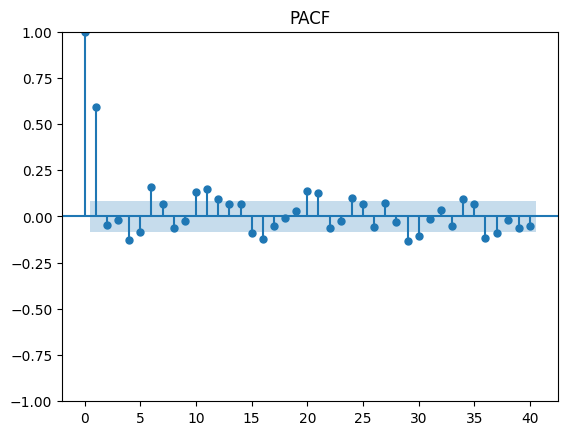

In [67]:
plot_acf(sales_ts, lags=40, alpha=0.05)
plt.title("ACF")
plt.show()

plot_pacf(sales_ts, lags=40, alpha=0.05)
plt.title("PACF")
plt.show()

In [68]:
from statsmodels.tsa.arima.model import ARIMA

In [69]:
sales_train = sales_ts[:310]
sales_test = sales_ts[310:]

### **Iterating to get Best order (p,d,q)**

In [70]:
best_mape = float('inf')
best_order = None

for p in range(4):
    for d in range(1,3):
        for q in range(4):
            try:
                model = ARIMA(sales_train, order=(p, d, q))
                model_fit = model.fit()
                fitted_vals_train = model_fit.fittedvalues

                mae , rmse , mape = performance(sales_train[:], fitted_vals_train[:])  # Skip initial d values

                print(f"p: {p}, d: {d}, q: {q} --> MAPE: {mape:.2f}%, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

                if mape < best_mape:
                    best_mape = mape
                    best_order = (p, d, q)
            except:
                continue

print("Best ARIMA order (p,d,q):", best_order, f"with MAPE: {best_mape:.2f}%")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1794413.01
RMSE: 2619461.01
MAPE: 12.07%
p: 0, d: 1, q: 0 --> MAPE: 12.07%, MAE: 1794413.01, RMSE: 2619461.01
MAE: 1808125.20
RMSE: 2594778.60
MAPE: 12.20%
p: 0, d: 1, q: 1 --> MAPE: 12.20%, MAE: 1808125.20, RMSE: 2594778.60
MAE: 1780280.32
RMSE: 2460230.92
MAPE: 12.16%
p: 0, d: 1, q: 2 --> MAPE: 12.16%, MAE: 1780280.32, RMSE: 2460230.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1714171.17
RMSE: 2408207.28
MAPE: 11.67%
p: 0, d: 1, q: 3 --> MAPE: 11.67%, MAE: 1714171.17, RMSE: 2408207.28
MAE: 2842528.26
RMSE: 3904589.45
MAPE: 18.72%
p: 0, d: 2, q: 0 --> MAPE: 18.72%, MAE: 2842528.26, RMSE: 3904589.45
MAE: 1866635.30
RMSE: 2728344.64
MAPE: 12.59%
p: 0, d: 2, q: 1 --> MAPE: 12.59%, MAE: 1866635.30, RMSE: 2728344.64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1880225.32
RMSE: 2718059.31
MAPE: 12.72%
p: 0, d: 2, q: 2 --> MAPE: 12.72%, MAE: 1880225.32, RMSE: 2718059.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1905708.84
RMSE: 2649763.06
MAPE: 13.18%
p: 0, d: 2, q: 3 --> MAPE: 13.18%, MAE: 1905708.84, RMSE: 2649763.06
MAE: 1796793.55
RMSE: 2603277.69
MAPE: 12.11%
p: 1, d: 1, q: 0 --> MAPE: 12.11%, MAE: 1796793.55, RMSE: 2603277.69


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1710320.49
RMSE: 2407268.88
MAPE: 11.57%
p: 1, d: 1, q: 1 --> MAPE: 11.57%, MAE: 1710320.49, RMSE: 2407268.88
MAE: 1691853.46
RMSE: 2393424.14
MAPE: 11.48%
p: 1, d: 1, q: 2 --> MAPE: 11.48%, MAE: 1691853.46, RMSE: 2393424.14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1691752.08
RMSE: 2393419.40
MAPE: 11.48%
p: 1, d: 1, q: 3 --> MAPE: 11.48%, MAE: 1691752.08, RMSE: 2393419.40
MAE: 2501750.56
RMSE: 3425306.30
MAPE: 16.57%
p: 1, d: 2, q: 0 --> MAPE: 16.57%, MAE: 2501750.56, RMSE: 3425306.30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1871603.89
RMSE: 2721196.54
MAPE: 12.65%
p: 1, d: 2, q: 1 --> MAPE: 12.65%, MAE: 1871603.89, RMSE: 2721196.54


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1861187.67
RMSE: 2722995.65
MAPE: 12.55%
p: 1, d: 2, q: 2 --> MAPE: 12.55%, MAE: 1861187.67, RMSE: 2722995.65


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1876515.06
RMSE: 2716794.60
MAPE: 12.69%
p: 1, d: 2, q: 3 --> MAPE: 12.69%, MAE: 1876515.06, RMSE: 2716794.60


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1789197.83
RMSE: 2562627.63
MAPE: 12.16%
p: 2, d: 1, q: 0 --> MAPE: 12.16%, MAE: 1789197.83, RMSE: 2562627.63


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1692701.29
RMSE: 2393189.96
MAPE: 11.48%
p: 2, d: 1, q: 1 --> MAPE: 11.48%, MAE: 1692701.29, RMSE: 2393189.96


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1670113.22
RMSE: 2366278.39
MAPE: 11.33%
p: 2, d: 1, q: 2 --> MAPE: 11.33%, MAE: 1670113.22, RMSE: 2366278.39


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1673578.92
RMSE: 2383213.27
MAPE: 11.34%
p: 2, d: 1, q: 3 --> MAPE: 11.34%, MAE: 1673578.92, RMSE: 2383213.27
MAE: 2242477.13
RMSE: 3096696.20
MAPE: 15.05%
p: 2, d: 2, q: 0 --> MAPE: 15.05%, MAE: 2242477.13, RMSE: 3096696.20


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE: 1872418.56
RMSE: 2685708.87
MAPE: 12.77%
p: 2, d: 2, q: 1 --> MAPE: 12.77%, MAE: 1872418.56, RMSE: 2685708.87


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1867260.11
RMSE: 2719132.01
MAPE: 12.61%
p: 2, d: 2, q: 2 --> MAPE: 12.61%, MAE: 1867260.11, RMSE: 2719132.01


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1795295.49
RMSE: 2636724.84
MAPE: 12.25%
p: 2, d: 2, q: 3 --> MAPE: 12.25%, MAE: 1795295.49, RMSE: 2636724.84
MAE: 1792476.75
RMSE: 2561707.75
MAPE: 12.19%
p: 3, d: 1, q: 0 --> MAPE: 12.19%, MAE: 1792476.75, RMSE: 2561707.75
MAE: 1692757.98
RMSE: 2392733.87
MAPE: 11.48%
p: 3, d: 1, q: 1 --> MAPE: 11.48%, MAE: 1692757.98, RMSE: 2392733.87


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1682901.88
RMSE: 2385366.98
MAPE: 11.41%
p: 3, d: 1, q: 2 --> MAPE: 11.41%, MAE: 1682901.88, RMSE: 2385366.98


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1640819.00
RMSE: 2348905.84
MAPE: 11.16%
p: 3, d: 1, q: 3 --> MAPE: 11.16%, MAE: 1640819.00, RMSE: 2348905.84
MAE: 2179049.99
RMSE: 2996995.19
MAPE: 14.68%
p: 3, d: 2, q: 0 --> MAPE: 14.68%, MAE: 2179049.99, RMSE: 2996995.19
MAE: 1874410.53
RMSE: 2685792.01
MAPE: 12.79%
p: 3, d: 2, q: 1 --> MAPE: 12.79%, MAE: 1874410.53, RMSE: 2685792.01


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1869581.52
RMSE: 2670550.38
MAPE: 12.75%
p: 3, d: 2, q: 2 --> MAPE: 12.75%, MAE: 1869581.52, RMSE: 2670550.38


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1799673.43
RMSE: 2634346.59
MAPE: 12.29%
p: 3, d: 2, q: 3 --> MAPE: 12.29%, MAE: 1799673.43, RMSE: 2634346.59
Best ARIMA order (p,d,q): (3, 1, 3) with MAPE: 11.16%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### **Fitting model on best order values**

In [71]:
# 1. Fit ARIMA(3,1,3) on training data
model = ARIMA(sales_train, order=(3, 1, 3))
model_fit = model.fit()

# 2. Forecast for length of test set
forecast = model_fit.forecast(steps=len(sales_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [72]:
performance(sales_test,forecast)

MAE: 2145399.42
RMSE: 2717632.59
MAPE: 14.93%


(2145399.4192649242,
 np.float64(2717632.5855401754),
 np.float64(14.925480244296693))

**The ARIMA model performed poorly compared to the previous machine learning models. It resulted in a high MAE of 2,145,399.42 and RMSE of 2,717,632.59, indicating large errors in the sales predictions. The MAPE of 14.93% also reflects significantly lower accuracy, with average prediction errors nearly 15% off from actual values. These results suggest that ARIMA may not be suitable for this dataset, likely due to its limitations in handling multiple stores, external features, or complex patterns that models like XGBoost can capture more effectively.**

# **SARIMAX**

In [73]:
# Copy to avoid modifying original
df_encoded = train.copy()

df_encoded.drop('ID', axis=1, inplace=True)
# Convert 'Date' to datetime if not done
df_encoded['Date'] = pd.to_datetime(df_encoded['Date'])

# Map Discount Yes/No to 1/0
df_encoded['Discount'] = df_encoded['Discount'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_encoded, columns=['Store_Type', 'Location_Type', 'Region_Code'])

# View the encoded dataframe
print(df_encoded.head())


   Store_id       Date  Holiday  Discount  Order     Sales  Store_Type_S1  \
0         1 2018-01-01        1         1      9  19191.00           True   
1       253 2018-01-01        1         1     60  51789.12          False   
2       252 2018-01-01        1         1     42  36868.20          False   
3       251 2018-01-01        1         1     23  19715.16          False   
4       250 2018-01-01        1         1     62  45614.52          False   

   Store_Type_S2  Store_Type_S3  Store_Type_S4  Location_Type_L1  \
0          False          False          False             False   
1          False          False           True             False   
2          False           True          False             False   
3           True          False          False             False   
4           True          False          False             False   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0             False              True             F

In [74]:
# Group by date and aggregate (mean makes sense for binary/one-hot)
exog_vars = df_encoded.drop(columns=['Sales', 'Store_id', 'Order'])
exog_daily = exog_vars.groupby('Date').mean()

# Also aggregate target
sales_ts = df_encoded.groupby('Date')['Sales'].sum()

In [75]:
sales_train = sales_ts[:310]
sales_test = sales_ts[310:]
exog_daily_train = exog_daily[:310]
exog_daily_test = exog_daily[310:]
exog_vars_train = exog_vars[:310]
exog_vars_test = exog_vars[310:]

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [77]:
# Parameter ranges
p_values = range(0, 3)
d_values = range(0, 2)  # Typically 0 or 1 is sufficient
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
seasonal_periods = [7]  # Weekly seasonality

best_mape = float("inf")
best_order = None
best_seasonal_order = None
best_metrics = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in seasonal_periods:
                            try:
                                model = SARIMAX(sales_train,
                                                exog=exog_daily_train,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                model_fit = model.fit(disp=False)
                                pred_train = model_fit.fittedvalues
                                mae, rmse, mape = performance(sales_train, pred_train)

                                print(f"order=({p},{d},{q}), seasonal=({P},{D},{Q},{s}) -> MAPE={mape:.2f}%")

                                if mape < best_mape:
                                    best_mape = mape
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                                    best_metrics = (mae, rmse, mape)

                            except Exception as e:
                                print(f"order=({p},{d},{q}), seasonal=({P},{D},{Q},{s}) failed. Reason: {e}")
                                continue

print("\n✅ Best Model:")
print(f"Order: {best_order}, Seasonal Order: {best_seasonal_order}")
print(f"MAE: {best_metrics[0]:.2f}, RMSE: {best_metrics[1]:.2f}, MAPE: {best_metrics[2]:.2f}%")




MAE: 1537403.65
RMSE: 1989335.56
MAPE: 10.38%
order=(0,0,0), seasonal=(0,0,0,7) -> MAPE=10.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1427648.78
RMSE: 1873727.59
MAPE: 9.67%
order=(0,0,0), seasonal=(0,0,1,7) -> MAPE=9.67%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1411878.43
RMSE: 1861038.80
MAPE: 9.57%
order=(0,0,0), seasonal=(0,0,2,7) -> MAPE=9.57%
MAE: 2024191.86
RMSE: 3243478.62
MAPE: 13.39%
order=(0,0,0), seasonal=(0,1,0,7) -> MAPE=13.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1857584.77
RMSE: 3219822.83
MAPE: 12.02%
order=(0,0,0), seasonal=(0,1,1,7) -> MAPE=12.02%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1944653.43
RMSE: 3467523.61
MAPE: 12.52%
order=(0,0,0), seasonal=(0,1,2,7) -> MAPE=12.52%
MAE: 1393332.58
RMSE: 1844817.01
MAPE: 9.45%
order=(0,0,0), seasonal=(1,0,0,7) -> MAPE=9.45%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1302437.63
RMSE: 1738608.53
MAPE: 8.87%
order=(0,0,0), seasonal=(1,0,1,7) -> MAPE=8.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1304205.26
RMSE: 1733216.03
MAPE: 8.89%
order=(0,0,0), seasonal=(1,0,2,7) -> MAPE=8.89%
MAE: 1948258.85
RMSE: 3241908.02
MAPE: 12.74%
order=(0,0,0), seasonal=(1,1,0,7) -> MAPE=12.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1865918.56
RMSE: 3248490.25
MAPE: 12.06%
order=(0,0,0), seasonal=(1,1,1,7) -> MAPE=12.06%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1912619.32
RMSE: 3289653.30
MAPE: 12.37%
order=(0,0,0), seasonal=(1,1,2,7) -> MAPE=12.37%
MAE: 1367684.60
RMSE: 1830179.07
MAPE: 9.28%
order=(0,0,0), seasonal=(2,0,0,7) -> MAPE=9.28%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1303345.58
RMSE: 1734565.50
MAPE: 8.88%
order=(0,0,0), seasonal=(2,0,1,7) -> MAPE=8.88%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1305404.34
RMSE: 1719575.02
MAPE: 8.85%
order=(0,0,0), seasonal=(2,0,2,7) -> MAPE=8.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1948325.79
RMSE: 3295935.04
MAPE: 12.66%
order=(0,0,0), seasonal=(2,1,0,7) -> MAPE=12.66%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1965883.33
RMSE: 3438519.18
MAPE: 12.67%
order=(0,0,0), seasonal=(2,1,1,7) -> MAPE=12.67%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1975487.09
RMSE: 3455776.57
MAPE: 12.73%
order=(0,0,0), seasonal=(2,1,2,7) -> MAPE=12.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1362300.05
RMSE: 1783509.83
MAPE: 9.29%
order=(0,0,1), seasonal=(0,0,0,7) -> MAPE=9.29%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1293761.82
RMSE: 1705436.85
MAPE: 8.86%
order=(0,0,1), seasonal=(0,0,1,7) -> MAPE=8.86%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1280240.26
RMSE: 1695433.13
MAPE: 8.77%
order=(0,0,1), seasonal=(0,0,2,7) -> MAPE=8.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1817166.61
RMSE: 2807710.19
MAPE: 12.15%
order=(0,0,1), seasonal=(0,1,0,7) -> MAPE=12.15%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1654794.51
RMSE: 2740775.47
MAPE: 10.87%
order=(0,0,1), seasonal=(0,1,1,7) -> MAPE=10.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1710342.13
RMSE: 2923773.30
MAPE: 11.16%
order=(0,0,1), seasonal=(0,1,2,7) -> MAPE=11.16%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1272597.24
RMSE: 1686768.08
MAPE: 8.72%
order=(0,0,1), seasonal=(1,0,0,7) -> MAPE=8.72%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1173667.48
RMSE: 1593708.42
MAPE: 8.07%
order=(0,0,1), seasonal=(1,0,1,7) -> MAPE=8.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1176507.23
RMSE: 1589632.92
MAPE: 8.09%
order=(0,0,1), seasonal=(1,0,2,7) -> MAPE=8.09%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1698830.77
RMSE: 2751513.60
MAPE: 11.28%
order=(0,0,1), seasonal=(1,1,0,7) -> MAPE=11.28%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1652808.59
RMSE: 2761947.91
MAPE: 10.84%
order=(0,0,1), seasonal=(1,1,1,7) -> MAPE=10.84%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1668964.03
RMSE: 2769544.33
MAPE: 10.92%
order=(0,0,1), seasonal=(1,1,2,7) -> MAPE=10.92%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1253033.15
RMSE: 1674689.81
MAPE: 8.58%
order=(0,0,1), seasonal=(2,0,0,7) -> MAPE=8.58%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1175779.74
RMSE: 1590498.47
MAPE: 8.09%
order=(0,0,1), seasonal=(2,0,1,7) -> MAPE=8.09%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1177362.48
RMSE: 1576940.17
MAPE: 8.06%
order=(0,0,1), seasonal=(2,0,2,7) -> MAPE=8.06%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1677176.48
RMSE: 2755819.25
MAPE: 11.08%
order=(0,0,1), seasonal=(2,1,0,7) -> MAPE=11.08%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1699271.19
RMSE: 2874250.22
MAPE: 11.11%
order=(0,0,1), seasonal=(2,1,1,7) -> MAPE=11.11%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1711140.92
RMSE: 2907801.66
MAPE: 11.17%
order=(0,0,1), seasonal=(2,1,2,7) -> MAPE=11.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1365050.65
RMSE: 1778796.63
MAPE: 9.30%
order=(0,0,2), seasonal=(0,0,0,7) -> MAPE=9.30%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1300219.10
RMSE: 1700811.94
MAPE: 8.89%
order=(0,0,2), seasonal=(0,0,1,7) -> MAPE=8.89%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1287648.30
RMSE: 1688289.67
MAPE: 8.80%
order=(0,0,2), seasonal=(0,0,2,7) -> MAPE=8.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1798639.48
RMSE: 2730836.62
MAPE: 12.02%
order=(0,0,2), seasonal=(0,1,0,7) -> MAPE=12.02%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1619971.90
RMSE: 2636008.67
MAPE: 10.63%
order=(0,0,2), seasonal=(0,1,1,7) -> MAPE=10.63%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1649768.05
RMSE: 2765518.84
MAPE: 10.76%
order=(0,0,2), seasonal=(0,1,2,7) -> MAPE=10.76%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1276251.30
RMSE: 1679959.32
MAPE: 8.73%
order=(0,0,2), seasonal=(1,0,0,7) -> MAPE=8.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1163037.00
RMSE: 1572940.49
MAPE: 7.99%
order=(0,0,2), seasonal=(1,0,1,7) -> MAPE=7.99%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1167191.51
RMSE: 1571178.66
MAPE: 8.01%
order=(0,0,2), seasonal=(1,0,2,7) -> MAPE=8.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1664159.32
RMSE: 2645857.73
MAPE: 11.05%
order=(0,0,2), seasonal=(1,1,0,7) -> MAPE=11.05%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1615181.81
RMSE: 2658712.59
MAPE: 10.58%
order=(0,0,2), seasonal=(1,1,1,7) -> MAPE=10.58%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1676815.28
RMSE: 2837603.84
MAPE: 10.92%
order=(0,0,2), seasonal=(1,1,2,7) -> MAPE=10.92%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1254308.59
RMSE: 1664115.63
MAPE: 8.58%
order=(0,0,2), seasonal=(2,0,0,7) -> MAPE=8.58%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1166214.79
RMSE: 1571455.68
MAPE: 8.01%
order=(0,0,2), seasonal=(2,0,1,7) -> MAPE=8.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1171794.69
RMSE: 1559397.07
MAPE: 8.01%
order=(0,0,2), seasonal=(2,0,2,7) -> MAPE=8.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1639823.05
RMSE: 2617874.75
MAPE: 10.83%
order=(0,0,2), seasonal=(2,1,0,7) -> MAPE=10.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1651893.88
RMSE: 2726022.43
MAPE: 10.79%
order=(0,0,2), seasonal=(2,1,1,7) -> MAPE=10.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1663073.90
RMSE: 2768950.75
MAPE: 10.85%
order=(0,0,2), seasonal=(2,1,2,7) -> MAPE=10.85%
MAE: 1549299.71
RMSE: 2204923.49
MAPE: 10.41%
order=(0,1,0), seasonal=(0,0,0,7) -> MAPE=10.41%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1493178.24
RMSE: 2107398.09
MAPE: 10.10%
order=(0,1,0), seasonal=(0,0,1,7) -> MAPE=10.10%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1470831.37
RMSE: 2087833.60
MAPE: 9.97%
order=(0,1,0), seasonal=(0,0,2,7) -> MAPE=9.97%
MAE: 1826308.83
RMSE: 2535367.11
MAPE: 12.50%
order=(0,1,0), seasonal=(0,1,0,7) -> MAPE=12.50%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1440796.03
RMSE: 2160339.36
MAPE: 9.85%
order=(0,1,0), seasonal=(0,1,1,7) -> MAPE=9.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1438010.99
RMSE: 2161660.71
MAPE: 9.84%
order=(0,1,0), seasonal=(0,1,2,7) -> MAPE=9.84%
MAE: 1471208.03
RMSE: 2091966.61
MAPE: 9.99%
order=(0,1,0), seasonal=(1,0,0,7) -> MAPE=9.99%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1394139.08
RMSE: 2067802.11
MAPE: 9.52%
order=(0,1,0), seasonal=(1,0,1,7) -> MAPE=9.52%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1388252.81
RMSE: 2072490.16
MAPE: 9.49%
order=(0,1,0), seasonal=(1,0,2,7) -> MAPE=9.49%
MAE: 1679210.50
RMSE: 2334696.91
MAPE: 11.43%
order=(0,1,0), seasonal=(1,1,0,7) -> MAPE=11.43%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1439814.53
RMSE: 2159984.44
MAPE: 9.85%
order=(0,1,0), seasonal=(1,1,1,7) -> MAPE=9.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1416601.69
RMSE: 2095258.49
MAPE: 9.70%
order=(0,1,0), seasonal=(1,1,2,7) -> MAPE=9.70%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1453505.36
RMSE: 2075553.56
MAPE: 9.88%
order=(0,1,0), seasonal=(2,0,0,7) -> MAPE=9.88%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1386584.79
RMSE: 2070585.34
MAPE: 9.48%
order=(0,1,0), seasonal=(2,0,1,7) -> MAPE=9.48%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1359265.54
RMSE: 2013841.03
MAPE: 9.32%
order=(0,1,0), seasonal=(2,0,2,7) -> MAPE=9.32%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1560864.67
RMSE: 2191402.78
MAPE: 10.70%
order=(0,1,0), seasonal=(2,1,0,7) -> MAPE=10.70%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1407438.36
RMSE: 2122798.04
MAPE: 9.66%
order=(0,1,0), seasonal=(2,1,1,7) -> MAPE=9.66%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1408581.86
RMSE: 2150298.43
MAPE: 9.66%
order=(0,1,0), seasonal=(2,1,2,7) -> MAPE=9.66%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1564698.18
RMSE: 2084423.99
MAPE: 10.59%
order=(0,1,1), seasonal=(0,0,0,7) -> MAPE=10.59%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1472859.74
RMSE: 2002300.34
MAPE: 9.98%
order=(0,1,1), seasonal=(0,0,1,7) -> MAPE=9.98%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1442311.34
RMSE: 1983283.22
MAPE: 9.77%
order=(0,1,1), seasonal=(0,0,2,7) -> MAPE=9.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1760794.68
RMSE: 2426535.71
MAPE: 12.11%
order=(0,1,1), seasonal=(0,1,0,7) -> MAPE=12.11%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1388352.73
RMSE: 2097470.66
MAPE: 9.56%
order=(0,1,1), seasonal=(0,1,1,7) -> MAPE=9.56%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1394212.16
RMSE: 2119858.50
MAPE: 9.60%
order=(0,1,1), seasonal=(0,1,2,7) -> MAPE=9.60%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1434297.18
RMSE: 1990535.36
MAPE: 9.74%
order=(0,1,1), seasonal=(1,0,0,7) -> MAPE=9.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1333419.82
RMSE: 1981832.64
MAPE: 9.14%
order=(0,1,1), seasonal=(1,0,1,7) -> MAPE=9.14%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1325406.25
RMSE: 1992087.20
MAPE: 9.11%
order=(0,1,1), seasonal=(1,0,2,7) -> MAPE=9.11%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1606392.56
RMSE: 2235938.52
MAPE: 11.05%
order=(0,1,1), seasonal=(1,1,0,7) -> MAPE=11.05%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1385217.05
RMSE: 2096538.51
MAPE: 9.53%
order=(0,1,1), seasonal=(1,1,1,7) -> MAPE=9.53%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1365074.66
RMSE: 2024944.04
MAPE: 9.38%
order=(0,1,1), seasonal=(1,1,2,7) -> MAPE=9.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1411386.38
RMSE: 1972295.43
MAPE: 9.61%
order=(0,1,1), seasonal=(2,0,0,7) -> MAPE=9.61%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1319331.91
RMSE: 1982086.01
MAPE: 9.06%
order=(0,1,1), seasonal=(2,0,1,7) -> MAPE=9.06%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1284671.26
RMSE: 1911764.05
MAPE: 8.82%
order=(0,1,1), seasonal=(2,0,2,7) -> MAPE=8.82%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1486114.56
RMSE: 2102021.75
MAPE: 10.22%
order=(0,1,1), seasonal=(2,1,0,7) -> MAPE=10.22%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1362292.16
RMSE: 2056514.14
MAPE: 9.37%
order=(0,1,1), seasonal=(2,1,1,7) -> MAPE=9.37%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1380048.51
RMSE: 2108651.64
MAPE: 9.50%
order=(0,1,1), seasonal=(2,1,2,7) -> MAPE=9.50%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1363887.60
RMSE: 1921241.50
MAPE: 9.33%
order=(0,1,2), seasonal=(0,0,0,7) -> MAPE=9.33%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1310277.35
RMSE: 1855808.72
MAPE: 9.00%
order=(0,1,2), seasonal=(0,0,1,7) -> MAPE=9.00%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1298918.60
RMSE: 1851088.43
MAPE: 8.92%
order=(0,1,2), seasonal=(0,0,2,7) -> MAPE=8.92%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1719271.21
RMSE: 2390905.89
MAPE: 11.85%
order=(0,1,2), seasonal=(0,1,0,7) -> MAPE=11.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1362454.79
RMSE: 2076028.28
MAPE: 9.43%
order=(0,1,2), seasonal=(0,1,1,7) -> MAPE=9.43%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1373965.68
RMSE: 2113741.88
MAPE: 9.52%
order=(0,1,2), seasonal=(0,1,2,7) -> MAPE=9.52%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1312379.51
RMSE: 1867176.35
MAPE: 9.06%
order=(0,1,2), seasonal=(1,0,0,7) -> MAPE=9.06%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1317488.02
RMSE: 1931755.71
MAPE: 9.07%
order=(0,1,2), seasonal=(1,0,1,7) -> MAPE=9.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1306659.01
RMSE: 1951563.40
MAPE: 9.02%
order=(0,1,2), seasonal=(1,0,2,7) -> MAPE=9.02%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1558240.27
RMSE: 2201714.04
MAPE: 10.74%
order=(0,1,2), seasonal=(1,1,0,7) -> MAPE=10.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1359206.85
RMSE: 2074293.80
MAPE: 9.41%
order=(0,1,2), seasonal=(1,1,1,7) -> MAPE=9.41%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1337714.11
RMSE: 2006143.80
MAPE: 9.26%
order=(0,1,2), seasonal=(1,1,2,7) -> MAPE=9.26%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1313906.75
RMSE: 1867238.31
MAPE: 9.07%
order=(0,1,2), seasonal=(2,0,0,7) -> MAPE=9.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1294245.16
RMSE: 1938281.87
MAPE: 8.93%
order=(0,1,2), seasonal=(2,0,1,7) -> MAPE=8.93%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1262816.64
RMSE: 1871619.75
MAPE: 8.72%
order=(0,1,2), seasonal=(2,0,2,7) -> MAPE=8.72%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1437636.43
RMSE: 2077143.87
MAPE: 9.97%
order=(0,1,2), seasonal=(2,1,0,7) -> MAPE=9.97%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1335444.54
RMSE: 2032312.45
MAPE: 9.24%
order=(0,1,2), seasonal=(2,1,1,7) -> MAPE=9.24%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1357856.81
RMSE: 2082088.97
MAPE: 9.40%
order=(0,1,2), seasonal=(2,1,2,7) -> MAPE=9.40%
MAE: 1407319.22
RMSE: 1791402.43
MAPE: 9.55%
order=(1,0,0), seasonal=(0,0,0,7) -> MAPE=9.55%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1319674.75
RMSE: 1703358.56
MAPE: 8.99%
order=(1,0,0), seasonal=(0,0,1,7) -> MAPE=8.99%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1295522.76
RMSE: 1685791.90
MAPE: 8.83%
order=(1,0,0), seasonal=(0,0,2,7) -> MAPE=8.83%
MAE: 1773894.09
RMSE: 2622117.06
MAPE: 11.89%
order=(1,0,0), seasonal=(0,1,0,7) -> MAPE=11.89%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1543984.00
RMSE: 2432813.81
MAPE: 10.19%
order=(1,0,0), seasonal=(0,1,1,7) -> MAPE=10.19%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1578215.69
RMSE: 2568631.67
MAPE: 10.34%
order=(1,0,0), seasonal=(0,1,2,7) -> MAPE=10.34%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1284353.17
RMSE: 1676266.06
MAPE: 8.77%
order=(1,0,0), seasonal=(1,0,0,7) -> MAPE=8.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1141217.47
RMSE: 1558641.50
MAPE: 7.85%
order=(1,0,0), seasonal=(1,0,1,7) -> MAPE=7.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1144478.29
RMSE: 1556833.39
MAPE: 7.87%
order=(1,0,0), seasonal=(1,0,2,7) -> MAPE=7.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1624510.68
RMSE: 2493769.06
MAPE: 10.84%
order=(1,0,0), seasonal=(1,1,0,7) -> MAPE=10.84%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1541039.08
RMSE: 2443846.40
MAPE: 10.17%
order=(1,0,0), seasonal=(1,1,1,7) -> MAPE=10.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1548433.33
RMSE: 2463117.77
MAPE: 10.18%
order=(1,0,0), seasonal=(1,1,2,7) -> MAPE=10.18%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1250699.85
RMSE: 1655841.96
MAPE: 8.55%
order=(1,0,0), seasonal=(2,0,0,7) -> MAPE=8.55%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1143804.57
RMSE: 1557259.14
MAPE: 7.87%
order=(1,0,0), seasonal=(2,0,1,7) -> MAPE=7.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1148984.82
RMSE: 1546139.15
MAPE: 7.87%
order=(1,0,0), seasonal=(2,0,2,7) -> MAPE=7.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1592203.51
RMSE: 2468490.32
MAPE: 10.57%
order=(1,0,0), seasonal=(2,1,0,7) -> MAPE=10.57%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1590950.57
RMSE: 2551221.00
MAPE: 10.44%
order=(1,0,0), seasonal=(2,1,1,7) -> MAPE=10.44%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1589745.88
RMSE: 2562043.76
MAPE: 10.42%
order=(1,0,0), seasonal=(2,1,2,7) -> MAPE=10.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1367102.38
RMSE: 1777628.11
MAPE: 9.32%
order=(1,0,1), seasonal=(0,0,0,7) -> MAPE=9.32%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1302022.41
RMSE: 1698702.50
MAPE: 8.90%
order=(1,0,1), seasonal=(0,0,1,7) -> MAPE=8.90%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1289148.57
RMSE: 1684128.18
MAPE: 8.80%
order=(1,0,1), seasonal=(0,0,2,7) -> MAPE=8.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1767784.94
RMSE: 2594780.93
MAPE: 11.85%
order=(1,0,1), seasonal=(0,1,0,7) -> MAPE=11.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1479448.30
RMSE: 2293128.69
MAPE: 9.79%
order=(1,0,1), seasonal=(0,1,1,7) -> MAPE=9.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1543388.59
RMSE: 2483491.38
MAPE: 10.12%
order=(1,0,1), seasonal=(0,1,2,7) -> MAPE=10.12%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1278043.58
RMSE: 1675559.90
MAPE: 8.74%
order=(1,0,1), seasonal=(1,0,0,7) -> MAPE=8.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1137664.30
RMSE: 1554248.48
MAPE: 7.81%
order=(1,0,1), seasonal=(1,0,1,7) -> MAPE=7.81%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1139281.03
RMSE: 1552994.69
MAPE: 7.83%
order=(1,0,1), seasonal=(1,0,2,7) -> MAPE=7.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1617233.55
RMSE: 2463902.58
MAPE: 10.79%
order=(1,0,1), seasonal=(1,1,0,7) -> MAPE=10.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1474513.98
RMSE: 2292727.85
MAPE: 9.75%
order=(1,0,1), seasonal=(1,1,1,7) -> MAPE=9.75%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1512802.82
RMSE: 2362617.12
MAPE: 9.96%
order=(1,0,1), seasonal=(1,1,2,7) -> MAPE=9.96%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1250218.57
RMSE: 1656006.20
MAPE: 8.55%
order=(1,0,1), seasonal=(2,0,0,7) -> MAPE=8.55%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1140322.95
RMSE: 1553487.03
MAPE: 7.83%
order=(1,0,1), seasonal=(2,0,1,7) -> MAPE=7.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1141227.69
RMSE: 1543030.90
MAPE: 7.81%
order=(1,0,1), seasonal=(2,0,2,7) -> MAPE=7.81%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1582837.78
RMSE: 2436700.83
MAPE: 10.51%
order=(1,0,1), seasonal=(2,1,0,7) -> MAPE=10.51%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1543186.10
RMSE: 2438241.98
MAPE: 10.14%
order=(1,0,1), seasonal=(2,1,1,7) -> MAPE=10.14%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1549740.83
RMSE: 2479961.82
MAPE: 10.16%
order=(1,0,1), seasonal=(2,1,2,7) -> MAPE=10.16%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1354912.64
RMSE: 1766416.83
MAPE: 9.25%
order=(1,0,2), seasonal=(0,0,0,7) -> MAPE=9.25%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1299082.46
RMSE: 1702886.99
MAPE: 8.89%
order=(1,0,2), seasonal=(0,0,1,7) -> MAPE=8.89%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1285882.52
RMSE: 1682383.94
MAPE: 8.78%
order=(1,0,2), seasonal=(0,0,2,7) -> MAPE=8.78%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1764653.88
RMSE: 2589761.73
MAPE: 11.83%
order=(1,0,2), seasonal=(0,1,0,7) -> MAPE=11.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1457490.51
RMSE: 2259974.24
MAPE: 9.67%
order=(1,0,2), seasonal=(0,1,1,7) -> MAPE=9.67%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1481338.26
RMSE: 2342462.76
MAPE: 9.77%
order=(1,0,2), seasonal=(0,1,2,7) -> MAPE=9.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1275858.56
RMSE: 1673586.95
MAPE: 8.73%
order=(1,0,2), seasonal=(1,0,0,7) -> MAPE=8.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1128835.22
RMSE: 1552639.87
MAPE: 7.76%
order=(1,0,2), seasonal=(1,0,1,7) -> MAPE=7.76%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1134853.86
RMSE: 1551973.69
MAPE: 7.80%
order=(1,0,2), seasonal=(1,0,2,7) -> MAPE=7.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1618226.62
RMSE: 2466501.34
MAPE: 10.80%
order=(1,0,2), seasonal=(1,1,0,7) -> MAPE=10.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1452463.58
RMSE: 2262627.32
MAPE: 9.63%
order=(1,0,2), seasonal=(1,1,1,7) -> MAPE=9.63%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1448822.81
RMSE: 2214379.73
MAPE: 9.61%
order=(1,0,2), seasonal=(1,1,2,7) -> MAPE=9.61%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1247460.62
RMSE: 1654752.44
MAPE: 8.54%
order=(1,0,2), seasonal=(2,0,0,7) -> MAPE=8.54%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1134514.57
RMSE: 1552223.21
MAPE: 7.80%
order=(1,0,2), seasonal=(2,0,1,7) -> MAPE=7.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1134457.56
RMSE: 1540857.02
MAPE: 7.77%
order=(1,0,2), seasonal=(2,0,2,7) -> MAPE=7.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1590322.07
RMSE: 2455371.89
MAPE: 10.55%
order=(1,0,2), seasonal=(2,1,0,7) -> MAPE=10.55%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1483935.60
RMSE: 2303313.23
MAPE: 9.79%
order=(1,0,2), seasonal=(2,1,1,7) -> MAPE=9.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1479426.38
RMSE: 2327397.89
MAPE: 9.74%
order=(1,0,2), seasonal=(2,1,2,7) -> MAPE=9.74%
MAE: 1568119.71
RMSE: 2179207.72
MAPE: 10.51%
order=(1,1,0), seasonal=(0,0,0,7) -> MAPE=10.51%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1494028.58
RMSE: 2072732.23
MAPE: 10.07%
order=(1,1,0), seasonal=(0,0,1,7) -> MAPE=10.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1465752.05
RMSE: 2050592.85
MAPE: 9.91%
order=(1,1,0), seasonal=(0,0,2,7) -> MAPE=9.91%
MAE: 1806339.99
RMSE: 2466650.84
MAPE: 12.36%
order=(1,1,0), seasonal=(0,1,0,7) -> MAPE=12.36%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1421886.73
RMSE: 2109050.31
MAPE: 9.72%
order=(1,1,0), seasonal=(0,1,1,7) -> MAPE=9.72%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1417864.54
RMSE: 2112394.65
MAPE: 9.69%
order=(1,1,0), seasonal=(0,1,2,7) -> MAPE=9.69%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1464785.53
RMSE: 2052093.91
MAPE: 9.93%
order=(1,1,0), seasonal=(1,0,0,7) -> MAPE=9.93%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1364376.19
RMSE: 2012144.84
MAPE: 9.31%
order=(1,1,0), seasonal=(1,0,1,7) -> MAPE=9.31%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1358026.50
RMSE: 2016336.01
MAPE: 9.27%
order=(1,1,0), seasonal=(1,0,2,7) -> MAPE=9.27%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1666199.70
RMSE: 2275538.32
MAPE: 11.36%
order=(1,1,0), seasonal=(1,1,0,7) -> MAPE=11.36%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1421479.84
RMSE: 2108681.03
MAPE: 9.71%
order=(1,1,0), seasonal=(1,1,1,7) -> MAPE=9.71%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1394346.47
RMSE: 2046092.00
MAPE: 9.53%
order=(1,1,0), seasonal=(1,1,2,7) -> MAPE=9.53%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1435485.39
RMSE: 2031932.50
MAPE: 9.75%
order=(1,1,0), seasonal=(2,0,0,7) -> MAPE=9.75%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1356169.53
RMSE: 2013244.91
MAPE: 9.26%
order=(1,1,0), seasonal=(2,0,1,7) -> MAPE=9.26%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1326833.38
RMSE: 1956748.52
MAPE: 9.07%
order=(1,1,0), seasonal=(2,0,2,7) -> MAPE=9.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1540756.93
RMSE: 2134212.06
MAPE: 10.54%
order=(1,1,0), seasonal=(2,1,0,7) -> MAPE=10.54%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1383942.40
RMSE: 2071483.19
MAPE: 9.48%
order=(1,1,0), seasonal=(2,1,1,7) -> MAPE=9.48%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1388161.73
RMSE: 2105783.83
MAPE: 9.50%
order=(1,1,0), seasonal=(2,1,2,7) -> MAPE=9.50%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1428668.65
RMSE: 1945903.24
MAPE: 9.77%
order=(1,1,1), seasonal=(0,0,0,7) -> MAPE=9.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1344263.87
RMSE: 1862538.14
MAPE: 9.23%
order=(1,1,1), seasonal=(0,0,1,7) -> MAPE=9.23%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1330644.58
RMSE: 1853575.03
MAPE: 9.15%
order=(1,1,1), seasonal=(0,0,2,7) -> MAPE=9.15%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1702236.05
RMSE: 2375303.78
MAPE: 11.75%
order=(1,1,1), seasonal=(0,1,0,7) -> MAPE=11.75%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1379352.00
RMSE: 2090121.90
MAPE: 9.53%
order=(1,1,1), seasonal=(0,1,1,7) -> MAPE=9.53%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1389665.25
RMSE: 2128054.93
MAPE: 9.63%
order=(1,1,1), seasonal=(0,1,2,7) -> MAPE=9.63%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1357995.20
RMSE: 1894294.39
MAPE: 9.31%
order=(1,1,1), seasonal=(1,0,0,7) -> MAPE=9.31%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1342541.66
RMSE: 1860223.24
MAPE: 9.22%
order=(1,1,1), seasonal=(1,0,1,7) -> MAPE=9.22%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1325235.34
RMSE: 1977396.78
MAPE: 9.14%
order=(1,1,1), seasonal=(1,0,2,7) -> MAPE=9.14%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1559794.70
RMSE: 2202636.43
MAPE: 10.77%
order=(1,1,1), seasonal=(1,1,0,7) -> MAPE=10.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1375092.73
RMSE: 2087834.64
MAPE: 9.50%
order=(1,1,1), seasonal=(1,1,1,7) -> MAPE=9.50%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1349304.27
RMSE: 2014245.43
MAPE: 9.34%
order=(1,1,1), seasonal=(1,1,2,7) -> MAPE=9.34%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1343270.87
RMSE: 1895586.93
MAPE: 9.24%
order=(1,1,1), seasonal=(2,0,0,7) -> MAPE=9.24%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1316523.94
RMSE: 1965213.48
MAPE: 9.08%
order=(1,1,1), seasonal=(2,0,1,7) -> MAPE=9.08%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1274134.21
RMSE: 1887379.44
MAPE: 8.79%
order=(1,1,1), seasonal=(2,0,2,7) -> MAPE=8.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1444133.18
RMSE: 2080434.48
MAPE: 10.03%
order=(1,1,1), seasonal=(2,1,0,7) -> MAPE=10.03%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1351844.99
RMSE: 2053364.87
MAPE: 9.36%
order=(1,1,1), seasonal=(2,1,1,7) -> MAPE=9.36%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1368808.62
RMSE: 2098592.53
MAPE: 9.48%
order=(1,1,1), seasonal=(2,1,2,7) -> MAPE=9.48%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1348132.72
RMSE: 1873203.36
MAPE: 9.19%
order=(1,1,2), seasonal=(0,0,0,7) -> MAPE=9.19%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1293207.61
RMSE: 1810164.17
MAPE: 8.90%
order=(1,1,2), seasonal=(0,0,1,7) -> MAPE=8.90%
MAE: 1289023.55
RMSE: 1830123.78
MAPE: 8.82%
order=(1,1,2), seasonal=(0,0,2,7) -> MAPE=8.82%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1704243.72
RMSE: 2377145.92
MAPE: 11.76%
order=(1,1,2), seasonal=(0,1,0,7) -> MAPE=11.76%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1361021.37
RMSE: 2072622.89
MAPE: 9.42%
order=(1,1,2), seasonal=(0,1,1,7) -> MAPE=9.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1373541.69
RMSE: 2112395.14
MAPE: 9.52%
order=(1,1,2), seasonal=(0,1,2,7) -> MAPE=9.52%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1300321.22
RMSE: 1828737.30
MAPE: 8.89%
order=(1,1,2), seasonal=(1,0,0,7) -> MAPE=8.89%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1291485.39
RMSE: 1868856.09
MAPE: 8.83%
order=(1,1,2), seasonal=(1,0,1,7) -> MAPE=8.83%
MAE: 1301050.02
RMSE: 1873676.16
MAPE: 8.87%
order=(1,1,2), seasonal=(1,0,2,7) -> MAPE=8.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1559494.09
RMSE: 2202181.37
MAPE: 10.76%
order=(1,1,2), seasonal=(1,1,0,7) -> MAPE=10.76%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1358372.75
RMSE: 2071274.49
MAPE: 9.39%
order=(1,1,2), seasonal=(1,1,1,7) -> MAPE=9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1337605.05
RMSE: 2006473.08
MAPE: 9.26%
order=(1,1,2), seasonal=(1,1,2,7) -> MAPE=9.26%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1292855.18
RMSE: 1831872.67
MAPE: 8.83%
order=(1,1,2), seasonal=(2,0,0,7) -> MAPE=8.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1292249.24
RMSE: 1866417.26
MAPE: 8.81%
order=(1,1,2), seasonal=(2,0,1,7) -> MAPE=8.81%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1263735.04
RMSE: 1872193.22
MAPE: 8.72%
order=(1,1,2), seasonal=(2,0,2,7) -> MAPE=8.72%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1441182.48
RMSE: 2077179.48
MAPE: 10.01%
order=(1,1,2), seasonal=(2,1,0,7) -> MAPE=10.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1335386.92
RMSE: 2034600.74
MAPE: 9.24%
order=(1,1,2), seasonal=(2,1,1,7) -> MAPE=9.24%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1357866.30
RMSE: 2082164.99
MAPE: 9.40%
order=(1,1,2), seasonal=(2,1,2,7) -> MAPE=9.40%
MAE: 1377121.87
RMSE: 1780937.09
MAPE: 9.37%
order=(2,0,0), seasonal=(0,0,0,7) -> MAPE=9.37%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1307950.73
RMSE: 1700113.63
MAPE: 8.93%
order=(2,0,0), seasonal=(0,0,1,7) -> MAPE=8.93%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1291056.97
RMSE: 1684669.02
MAPE: 8.81%
order=(2,0,0), seasonal=(0,0,2,7) -> MAPE=8.81%
MAE: 1771047.15
RMSE: 2608391.08
MAPE: 11.87%
order=(2,0,0), seasonal=(0,1,0,7) -> MAPE=11.87%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1524303.57
RMSE: 2384393.70
MAPE: 10.06%
order=(2,0,0), seasonal=(0,1,1,7) -> MAPE=10.06%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1558666.90
RMSE: 2523154.77
MAPE: 10.22%
order=(2,0,0), seasonal=(0,1,2,7) -> MAPE=10.22%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1280807.28
RMSE: 1675599.15
MAPE: 8.75%
order=(2,0,0), seasonal=(1,0,0,7) -> MAPE=8.75%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1139650.19
RMSE: 1554892.83
MAPE: 7.83%
order=(2,0,0), seasonal=(1,0,1,7) -> MAPE=7.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1142417.50
RMSE: 1553639.95
MAPE: 7.85%
order=(2,0,0), seasonal=(1,0,2,7) -> MAPE=7.85%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1617756.04
RMSE: 2467460.73
MAPE: 10.80%
order=(2,0,0), seasonal=(1,1,0,7) -> MAPE=10.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1523146.02
RMSE: 2401659.80
MAPE: 10.05%
order=(2,0,0), seasonal=(1,1,1,7) -> MAPE=10.05%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1527929.34
RMSE: 2415376.57
MAPE: 10.05%
order=(2,0,0), seasonal=(1,1,2,7) -> MAPE=10.05%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1250110.98
RMSE: 1655876.33
MAPE: 8.55%
order=(2,0,0), seasonal=(2,0,0,7) -> MAPE=8.55%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1141157.40
RMSE: 1553885.43
MAPE: 7.84%
order=(2,0,0), seasonal=(2,0,1,7) -> MAPE=7.84%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1143483.89
RMSE: 1543686.32
MAPE: 7.83%
order=(2,0,0), seasonal=(2,0,2,7) -> MAPE=7.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1583751.20
RMSE: 2440556.68
MAPE: 10.52%
order=(2,0,0), seasonal=(2,1,0,7) -> MAPE=10.52%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1574201.65
RMSE: 2519190.41
MAPE: 10.33%
order=(2,0,0), seasonal=(2,1,1,7) -> MAPE=10.33%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1573142.56
RMSE: 2539000.91
MAPE: 10.30%
order=(2,0,0), seasonal=(2,1,2,7) -> MAPE=10.30%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1367411.71
RMSE: 1776444.41
MAPE: 9.32%
order=(2,0,1), seasonal=(0,0,0,7) -> MAPE=9.32%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1299498.51
RMSE: 1696662.07
MAPE: 8.88%
order=(2,0,1), seasonal=(0,0,1,7) -> MAPE=8.88%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1286149.41
RMSE: 1682609.17
MAPE: 8.78%
order=(2,0,1), seasonal=(0,0,2,7) -> MAPE=8.78%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1725337.61
RMSE: 2380578.20
MAPE: 11.73%
order=(2,0,1), seasonal=(0,1,0,7) -> MAPE=11.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1410644.99
RMSE: 2100305.56
MAPE: 9.51%
order=(2,0,1), seasonal=(0,1,1,7) -> MAPE=9.51%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1400394.31
RMSE: 2119262.31
MAPE: 9.40%
order=(2,0,1), seasonal=(0,1,2,7) -> MAPE=9.40%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1276046.08
RMSE: 1673737.65
MAPE: 8.73%
order=(2,0,1), seasonal=(1,0,0,7) -> MAPE=8.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1132110.46
RMSE: 1552916.27
MAPE: 7.78%
order=(2,0,1), seasonal=(1,0,1,7) -> MAPE=7.78%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1136157.28
RMSE: 1552487.33
MAPE: 7.81%
order=(2,0,1), seasonal=(1,0,2,7) -> MAPE=7.81%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1536351.60
RMSE: 2174013.23
MAPE: 10.40%
order=(2,0,1), seasonal=(1,1,0,7) -> MAPE=10.40%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1418172.85
RMSE: 2097904.01
MAPE: 9.57%
order=(2,0,1), seasonal=(1,1,1,7) -> MAPE=9.57%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1408136.62
RMSE: 2098870.03
MAPE: 9.38%
order=(2,0,1), seasonal=(1,1,2,7) -> MAPE=9.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1248359.22
RMSE: 1655456.21
MAPE: 8.54%
order=(2,0,1), seasonal=(2,0,0,7) -> MAPE=8.54%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1135618.38
RMSE: 1552773.71
MAPE: 7.80%
order=(2,0,1), seasonal=(2,0,1,7) -> MAPE=7.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1135677.20
RMSE: 1540710.47
MAPE: 7.78%
order=(2,0,1), seasonal=(2,0,2,7) -> MAPE=7.78%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1646231.05
RMSE: 2322731.61
MAPE: 11.13%
order=(2,0,1), seasonal=(2,1,0,7) -> MAPE=11.13%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1801555.95
RMSE: 2608728.79
MAPE: 12.08%
order=(2,0,1), seasonal=(2,1,1,7) -> MAPE=12.08%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1798144.70
RMSE: 2644611.58
MAPE: 12.03%
order=(2,0,1), seasonal=(2,1,2,7) -> MAPE=12.03%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 3150655.72
RMSE: 4087473.91
MAPE: 20.77%
order=(2,0,2), seasonal=(0,0,0,7) -> MAPE=20.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1299833.43
RMSE: 1694000.86
MAPE: 8.88%
order=(2,0,2), seasonal=(0,0,1,7) -> MAPE=8.88%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 17249196.21
RMSE: 111980195.04
MAPE: 107.10%
order=(2,0,2), seasonal=(0,0,2,7) -> MAPE=107.10%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1768924.88
RMSE: 2621213.69
MAPE: 11.86%
order=(2,0,2), seasonal=(0,1,0,7) -> MAPE=11.86%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1410535.65
RMSE: 2138889.84
MAPE: 9.39%
order=(2,0,2), seasonal=(0,1,1,7) -> MAPE=9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1417785.69
RMSE: 2166983.74
MAPE: 9.42%
order=(2,0,2), seasonal=(0,1,2,7) -> MAPE=9.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 2926865.82
RMSE: 3842226.55
MAPE: 19.26%
order=(2,0,2), seasonal=(1,0,0,7) -> MAPE=19.26%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1133303.87
RMSE: 1545801.92
MAPE: 7.80%
order=(2,0,2), seasonal=(1,0,1,7) -> MAPE=7.80%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 17035979.62
RMSE: 111060162.43
MAPE: 105.77%
order=(2,0,2), seasonal=(1,0,2,7) -> MAPE=105.77%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1617654.81
RMSE: 2488784.09
MAPE: 10.79%
order=(2,0,2), seasonal=(1,1,0,7) -> MAPE=10.79%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1411963.30
RMSE: 2149182.84
MAPE: 9.39%
order=(2,0,2), seasonal=(1,1,1,7) -> MAPE=9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1361501.36
RMSE: 2010455.38
MAPE: 9.11%
order=(2,0,2), seasonal=(1,1,2,7) -> MAPE=9.11%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 18736435.25
RMSE: 127819219.21
MAPE: 118.95%
order=(2,0,2), seasonal=(2,0,0,7) -> MAPE=118.95%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 18579988.20
RMSE: 127091614.85
MAPE: 117.94%
order=(2,0,2), seasonal=(2,0,1,7) -> MAPE=117.94%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 17030802.59
RMSE: 111015335.47
MAPE: 105.73%
order=(2,0,2), seasonal=(2,0,2,7) -> MAPE=105.73%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1586877.82
RMSE: 2469972.84
MAPE: 10.53%
order=(2,0,2), seasonal=(2,1,0,7) -> MAPE=10.53%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1417999.36
RMSE: 2138439.52
MAPE: 9.40%
order=(2,0,2), seasonal=(2,1,1,7) -> MAPE=9.40%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1419360.34
RMSE: 2177699.31
MAPE: 9.39%
order=(2,0,2), seasonal=(2,1,2,7) -> MAPE=9.39%
MAE: 1519576.30
RMSE: 2099375.38
MAPE: 10.27%
order=(2,1,0), seasonal=(0,0,0,7) -> MAPE=10.27%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1446027.77
RMSE: 2013556.23
MAPE: 9.83%
order=(2,1,0), seasonal=(0,0,1,7) -> MAPE=9.83%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1417836.31
RMSE: 1997971.35
MAPE: 9.65%
order=(2,1,0), seasonal=(0,0,2,7) -> MAPE=9.65%
MAE: 1760570.96
RMSE: 2433286.91
MAPE: 12.13%
order=(2,1,0), seasonal=(0,1,0,7) -> MAPE=12.13%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1367888.93
RMSE: 2078143.16
MAPE: 9.42%
order=(2,1,0), seasonal=(0,1,1,7) -> MAPE=9.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1364687.11
RMSE: 2080581.65
MAPE: 9.39%
order=(2,1,0), seasonal=(0,1,2,7) -> MAPE=9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1420728.24
RMSE: 2004102.57
MAPE: 9.69%
order=(2,1,0), seasonal=(1,0,0,7) -> MAPE=9.69%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1315633.97
RMSE: 1976122.84
MAPE: 9.03%
order=(2,1,0), seasonal=(1,0,1,7) -> MAPE=9.03%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1310375.39
RMSE: 1979054.90
MAPE: 9.00%
order=(2,1,0), seasonal=(1,0,2,7) -> MAPE=9.00%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1614851.51
RMSE: 2245371.93
MAPE: 11.08%
order=(2,1,0), seasonal=(1,1,0,7) -> MAPE=11.08%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1366565.65
RMSE: 2077910.16
MAPE: 9.41%
order=(2,1,0), seasonal=(1,1,1,7) -> MAPE=9.41%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1350540.39
RMSE: 2012339.64
MAPE: 9.28%
order=(2,1,0), seasonal=(1,1,2,7) -> MAPE=9.28%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1397607.73
RMSE: 1988890.65
MAPE: 9.54%
order=(2,1,0), seasonal=(2,0,0,7) -> MAPE=9.54%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1307429.74
RMSE: 1977051.99
MAPE: 8.98%
order=(2,1,0), seasonal=(2,0,1,7) -> MAPE=8.98%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1283424.33
RMSE: 1915263.38
MAPE: 8.81%
order=(2,1,0), seasonal=(2,0,2,7) -> MAPE=8.81%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1496641.25
RMSE: 2106865.96
MAPE: 10.30%
order=(2,1,0), seasonal=(2,1,0,7) -> MAPE=10.30%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1352725.12
RMSE: 2042932.76
MAPE: 9.31%
order=(2,1,0), seasonal=(2,1,1,7) -> MAPE=9.31%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1364816.84
RMSE: 2078188.84
MAPE: 9.38%
order=(2,1,0), seasonal=(2,1,2,7) -> MAPE=9.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1361138.16
RMSE: 1911068.77
MAPE: 9.35%
order=(2,1,1), seasonal=(0,0,0,7) -> MAPE=9.35%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1316101.24
RMSE: 1845326.15
MAPE: 9.07%
order=(2,1,1), seasonal=(0,0,1,7) -> MAPE=9.07%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1307286.67
RMSE: 1839260.71
MAPE: 9.02%
order=(2,1,1), seasonal=(0,0,2,7) -> MAPE=9.02%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1704087.21
RMSE: 2377215.83
MAPE: 11.76%
order=(2,1,1), seasonal=(0,1,0,7) -> MAPE=11.76%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1361111.60
RMSE: 2078553.74
MAPE: 9.41%
order=(2,1,1), seasonal=(0,1,1,7) -> MAPE=9.41%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1370117.08
RMSE: 2113471.13
MAPE: 9.50%
order=(2,1,1), seasonal=(0,1,2,7) -> MAPE=9.50%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1333640.38
RMSE: 1874167.55
MAPE: 9.17%
order=(2,1,1), seasonal=(1,0,0,7) -> MAPE=9.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1320098.58
RMSE: 1944356.81
MAPE: 9.09%
order=(2,1,1), seasonal=(1,0,1,7) -> MAPE=9.09%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1305064.46
RMSE: 1963980.52
MAPE: 9.01%
order=(2,1,1), seasonal=(1,0,2,7) -> MAPE=9.01%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1561631.95
RMSE: 2205277.12
MAPE: 10.78%
order=(2,1,1), seasonal=(1,1,0,7) -> MAPE=10.78%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1357437.23
RMSE: 2076946.72
MAPE: 9.38%
order=(2,1,1), seasonal=(1,1,1,7) -> MAPE=9.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1337497.39
RMSE: 2006081.18
MAPE: 9.26%
order=(2,1,1), seasonal=(1,1,2,7) -> MAPE=9.26%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1330909.63
RMSE: 1879521.36
MAPE: 9.17%
order=(2,1,1), seasonal=(2,0,0,7) -> MAPE=9.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1298971.37
RMSE: 1954950.84
MAPE: 8.96%
order=(2,1,1), seasonal=(2,0,1,7) -> MAPE=8.96%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1261748.69
RMSE: 1879640.95
MAPE: 8.71%
order=(2,1,1), seasonal=(2,0,2,7) -> MAPE=8.71%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1452934.81
RMSE: 2093327.98
MAPE: 10.10%
order=(2,1,1), seasonal=(2,1,0,7) -> MAPE=10.10%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1343809.08
RMSE: 2053744.97
MAPE: 9.31%
order=(2,1,1), seasonal=(2,1,1,7) -> MAPE=9.31%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1356337.37
RMSE: 2086972.73
MAPE: 9.39%
order=(2,1,1), seasonal=(2,1,2,7) -> MAPE=9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1433013.78
RMSE: 2034476.03
MAPE: 9.69%
order=(2,1,2), seasonal=(0,0,0,7) -> MAPE=9.69%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1269440.53
RMSE: 1807566.11
MAPE: 8.70%
order=(2,1,2), seasonal=(0,0,1,7) -> MAPE=8.70%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1302374.91
RMSE: 1821193.44
MAPE: 8.94%
order=(2,1,2), seasonal=(0,0,2,7) -> MAPE=8.94%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 2251736.97
RMSE: 2949236.52
MAPE: 15.31%
order=(2,1,2), seasonal=(0,1,0,7) -> MAPE=15.31%
MAE: 1701015.37
RMSE: 2361364.89
MAPE: 11.66%
order=(2,1,2), seasonal=(0,1,1,7) -> MAPE=11.66%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1433079.82
RMSE: 2107230.99
MAPE: 9.74%
order=(2,1,2), seasonal=(0,1,2,7) -> MAPE=9.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1332501.32
RMSE: 1855273.65
MAPE: 9.08%
order=(2,1,2), seasonal=(1,0,0,7) -> MAPE=9.08%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1289983.87
RMSE: 1870181.22
MAPE: 8.80%
order=(2,1,2), seasonal=(1,0,1,7) -> MAPE=8.80%
MAE: 1299201.79
RMSE: 1904680.98
MAPE: 8.90%
order=(2,1,2), seasonal=(1,0,2,7) -> MAPE=8.90%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1974910.66
RMSE: 2541275.36
MAPE: 13.38%
order=(2,1,2), seasonal=(1,1,0,7) -> MAPE=13.38%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1502595.64
RMSE: 2223723.64
MAPE: 10.18%
order=(2,1,2), seasonal=(1,1,1,7) -> MAPE=10.18%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1554848.68
RMSE: 2306882.87
MAPE: 10.56%
order=(2,1,2), seasonal=(1,1,2,7) -> MAPE=10.56%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

MAE: 1307214.89
RMSE: 1847972.16
MAPE: 8.92%
order=(2,1,2), seasonal=(2,0,0,7) -> MAPE=8.92%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1274940.41
RMSE: 1871221.39
MAPE: 8.71%
order=(2,1,2), seasonal=(2,0,1,7) -> MAPE=8.71%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1251904.29
RMSE: 1873750.89
MAPE: 8.60%
order=(2,1,2), seasonal=(2,0,2,7) -> MAPE=8.60%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1673700.06
RMSE: 2599123.75
MAPE: 11.41%
order=(2,1,2), seasonal=(2,1,0,7) -> MAPE=11.41%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1413703.12
RMSE: 2112025.50
MAPE: 9.58%
order=(2,1,2), seasonal=(2,1,1,7) -> MAPE=9.58%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1560474.42
RMSE: 2326169.71
MAPE: 10.48%
order=(2,1,2), seasonal=(2,1,2,7) -> MAPE=10.48%

✅ Best Model:
Order: (1, 0, 2), Seasonal Order: (1, 0, 1, 7)
MAE: 1128835.22, RMSE: 1552639.87, MAPE: 7.76%


In [78]:
model = SARIMAX(sales_test,
               exog=exog_daily_test,
                                                order=(2, 0, 2),
                                                seasonal_order=(2, 0, 2, 7),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
model_fit = model.fit(disp=False)
preds_test = model_fit.fittedvalues
performance(sales_test, preds_test)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1184479.59
RMSE: 1714091.21
MAPE: 8.51%


(1184479.58693394,
 np.float64(1714091.209403391),
 np.float64(8.506366864837716))

**The SARIMAX model showed an improvement over ARIMA, with a MAE of 1,184,479.59 and RMSE of 1,714,091.21, indicating reduced prediction errors. The MAPE of 8.51% also reflects a better fit, with average prediction errors significantly lower than ARIMA’s 14.93%. By incorporating both seasonal patterns and exogenous variables, SARIMAX was better able to capture the structure of the data. However, it still underperforms compared to machine learning models like XGBoost, suggesting that while SARIMAX improves over traditional statistical models, it may struggle with the complexity and variability present in large, multi-store datasets.**

# **PROPHET**

In [79]:
df_train = train.copy()
df_test = test.copy()

In [80]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [81]:
df_train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,19191.00
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [82]:
df_test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [83]:
# Rename columns to Prophet requirements
df_train = df_train.rename(columns={"Date": "ds", "Sales": "y"})
df_test = df_test.rename(columns={"Date": "ds", "Sales": "y"})

In [84]:
# Convert categorical columns
cat_cols = ["Store_id", "Store_Type", "Location_Type", "Region_Code", "Discount"]
for col in cat_cols:
    df_train[col] = df_train[col].astype("category")
    df_test[col] = df_test[col].astype("category")

In [85]:
# Prophet can handle binary features like Holiday directly
df_train["Holiday"] = df_train["Holiday"].astype(int)
df_test["Holiday"] = df_test["Holiday"].astype(int)

In [86]:
# Define train/test split point (e.g., last 20% for test)
split_point = int(len(df) * 0.8)

train = df_train.iloc[:split_point]
test = df_train.iloc[split_point:]

In [87]:
from prophet import Prophet

# Initialize model
m = Prophet()

# Encode and add regressors
for col in cat_cols:
    train[col] = train[col].cat.codes
    m.add_regressor(col)

m.add_regressor("Holiday")

# Fit the model
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_cl66k5f/_8qov2lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_cl66k5f/gpvu3t2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44672', 'data', 'file=/tmp/tmp_cl66k5f/_8qov2lx.json', 'init=/tmp/tmp_cl66k5f/gpvu3t2v.json', 'output', 'file=/tmp/tmp_cl66k5f/prophet_modelbyei1lbk/prophet_model-20250517113603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,ds,Holiday,Discount,Order,y
0,T1000001,0,0,2,0,2018-01-01,1,1,9,19191.00
1,T1000002,252,3,1,0,2018-01-01,1,1,60,51789.12
2,T1000003,251,2,1,0,2018-01-01,1,1,42,36868.20
3,T1000004,250,1,2,0,2018-01-01,1,1,23,19715.16
4,T1000005,249,1,2,3,2018-01-01,1,1,62,45614.52


In [89]:
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,ds,Holiday,Discount,Order,y
17812,T1017813,360,S2,L1,R1,2018-02-18,0,Yes,61,42627.0
17813,T1017814,257,S1,L3,R1,2018-02-18,0,Yes,73,41640.0
17814,T1017815,258,S2,L4,R4,2018-02-18,0,Yes,58,41349.0
17815,T1017816,87,S4,L2,R3,2018-02-18,0,Yes,122,76809.3
17816,T1017817,182,S3,L1,R1,2018-02-18,0,Yes,76,42888.0


In [90]:
train_forecast = m.predict(train)

In [91]:
performance(train["y"], train_forecast["yhat"])

MAE: 7533.64
RMSE: 9752.18
MAPE: 19.63%


(7533.639910785649,
 np.float64(9752.177907403222),
 np.float64(19.626209091080103))

**This suggests the model may be missing key patterns or is not well-tuned. It could be due to inappropriate parameters, insufficient handling of seasonality, or lack of relevant features. Compared to earlier models like XGBoost, this performance is significantly worse, indicating a need for refinement or switching back to more powerful approaches.**

# **Comparison of Model Performance and Conclusion**

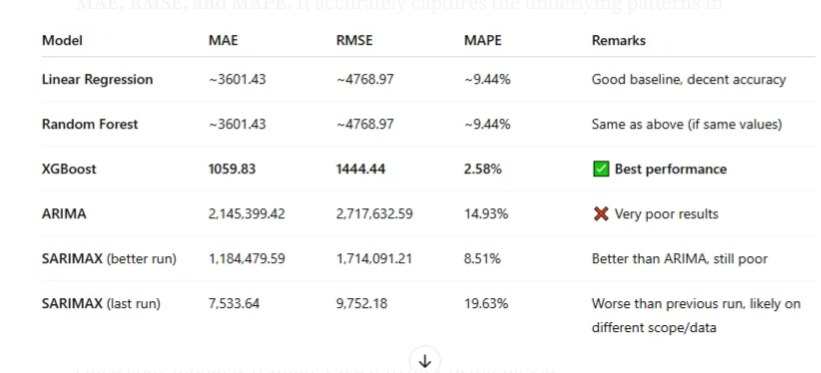


**XGBoost is clearly the best-performing model among all, with the lowest MAE, RMSE, and MAPE. It accurately captures the underlying patterns in the data and provides the most reliable forecasts.**

In [92]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9754141089595671), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(1.8107728991724996), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.12109845047028002), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=301, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### **Saving our best model and columns for deployment**

In [55]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [56]:
# Save list of feature names
feature_names = X_train.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)